In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs
from mejiro.lenses import lens_util

Using 41 systems, early-type galaxies 
$$0.2<z<0.8$$
and combining with lower-redshift SLACS sample gives virial-to-stellar mass fraction of early-type galaxies
$$(51 \pm 36)(1 + z)^{(0.9\pm1.8)}$$

In [2]:
detectable_lenses = lens_util.get_detectable_lenses(config.machine.pipeline_dir, with_subhalos=True)
print(f'Number of detectable lenses: {len(detectable_lenses)}')

100%|██████████| 1098/1098 [01:22<00:00, 13.28it/s]

Number of detectable lenses: 1098


In [34]:
lens_stellar_masses = [l.lens_stellar_mass for l in detectable_lenses]
main_halo_masses = [l.lens_stellar_mass * 51 * (1 + l.z_lens) ** 0.9 for l in detectable_lenses]

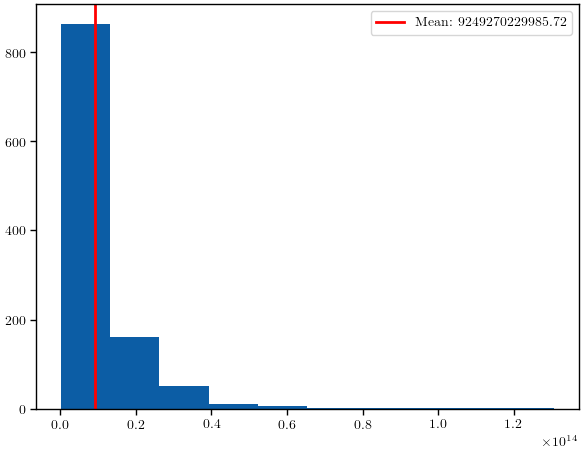

In [37]:
plt.hist(main_halo_masses)
plt.axvline(np.mean(main_halo_masses), label=f'Mean: {np.mean(main_halo_masses):.2f}', color='r')
plt.legend()
plt.show()

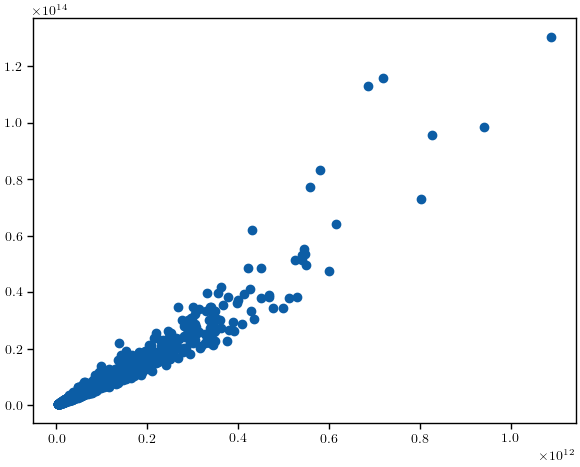

In [17]:
plt.scatter(lens_stellar_masses, main_halo_masses)
plt.show()